In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns; 
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)

## Kernelized Regression

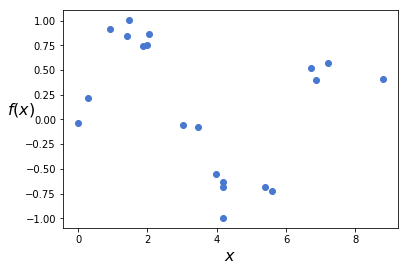

In [2]:
np.random.seed(1)
x = np.random.uniform(0, 10, size=20)
y = np.random.normal(np.sin(x), 0.2)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16);
plt.ylabel('$f(x)$', fontsize=16, rotation=0);

In [3]:
def gauss_kernel(x, n_knots):
    """
    Simple Gaussian radial kernel
    """
    knots = np.linspace(x.min(), x.max(), n_knots)    
    w = 2 
    return np.array([np.exp(-(x-k)**2/w) for k in knots])

In [4]:
n_knots = 5

In [5]:
with pm.Model() as kernel_model:
    gamma = pm.Cauchy('gamma', alpha=0, beta=1, shape=n_knots)
    sd = pm.Uniform('sd',0,  10)
    mu = pm.math.dot(gamma, gauss_kernel(x, n_knots))
    yl = pm.Normal('yl', mu=mu, sd=sd, observed=y)
    kernel_trace = pm.sample(10000, chains=1,njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sd, gamma]
100%|██████████| 10500/10500 [00:08<00:00, 1168.71it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


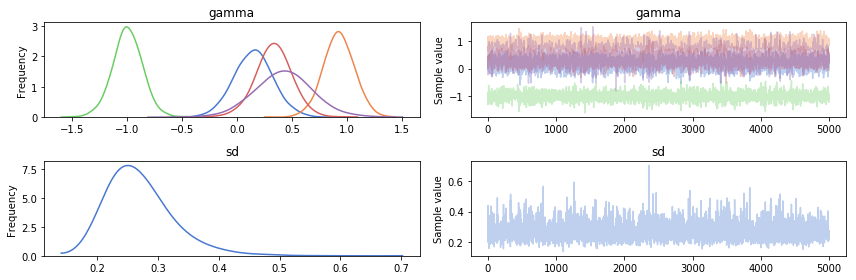

In [6]:
chain = kernel_trace[5000:]
pm.traceplot(chain);

In [7]:
pm.summary(chain)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
gamma__0,0.149587,0.178287,0.002675,-0.188123,0.513712
gamma__1,0.927369,0.140474,0.002009,0.640079,1.194028
gamma__2,-0.997580,0.135827,0.002167,-1.271611,-0.731901
gamma__3,0.335250,0.165045,0.002291,-0.006687,0.649435
gamma__4,0.425855,0.261586,0.003824,-0.108575,0.927639
sd,0.270219,0.054199,0.000974,0.185070,0.385145


100%|██████████| 100/100 [00:00<00:00, 1341.11it/s]


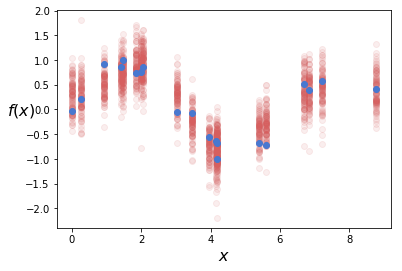

In [8]:
ppc = pm.sample_posterior_predictive(chain, model=kernel_model, samples=100)
plt.plot(x, ppc['yl'].T, 'ro', alpha=0.1);
plt.plot(x, y, 'bo');
plt.xlabel('$x$', fontsize=16);
plt.ylabel('$f(x)$', fontsize=16, rotation=0);

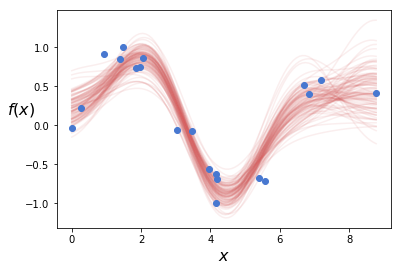

In [9]:
new_x = np.linspace(x.min(), x.max(), 100)
k = gauss_kernel(new_x, n_knots)
gamma_pred = chain['gamma']
for i in range(100):
    idx = np.random.randint(0, len(gamma_pred))
    # grap a random set of gammas from the MCMC chain
    # e.g. gamma_pred[3642]=[-0.04  0.93 -0.97  0.32  0.05]
    # to get an idea of the uncertainty
    y_pred = np.dot(gamma_pred[idx], k)
    plt.plot(new_x, y_pred, 'r-', alpha=0.1)
plt.plot(x, y, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0);

## Gaussian Processes

In [10]:
squared_distance = lambda x, y: np.array([[(x[i] - y[j])**2 for i in range(len(x))] for j in range(len(y))])

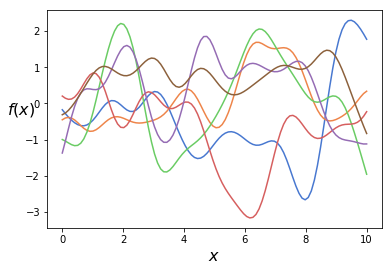

In [11]:
np.random.seed(1)
test_points = np.linspace(0, 10, 100)
cov = np.exp(-squared_distance(test_points, test_points))
plt.plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=6).T);
plt.xlabel('$x$', fontsize=16);
plt.ylabel('$f(x)$', fontsize=16, rotation=0);

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/scipy/stats/_multivariate.py:660: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


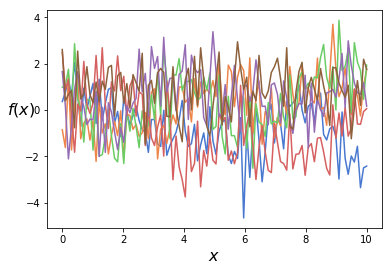

In [12]:
np.random.seed(1)
eta = 1
rho = 0.5
sigma = 0.03
D = squared_distance(test_points, test_points)

cov = eta * np.exp(-rho * D)
diag = eta * sigma

np.fill_diagonal(cov, diag)

for i in range(6):
    plt.plot(test_points, stats.multivariate_normal.rvs(cov=cov))
plt.xlabel('$x$', fontsize=16);
plt.ylabel('$f(x)$', fontsize=16, rotation=0);

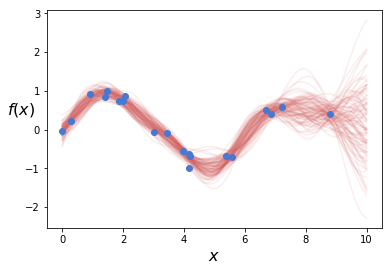

In [13]:
np.random.seed(1)
# K_{**}
K_oo = eta * np.exp(-rho * D) 

D_x = squared_distance(x, x)
# K
K = eta * np.exp(-rho * D_x)
diag_x = eta + sigma
np.fill_diagonal(K, diag_x)

D_off_diag = squared_distance(x, test_points)
# K_{*}
K_o = eta * np.exp(-rho * D_off_diag)

# Posterior mean
mu_post = np.dot(np.dot(K_o, np.linalg.inv(K)), y)
# Posterior covariance
SIGMA_post = K_oo - np.dot(np.dot(K_o, np.linalg.inv(K)), K_o.T)


for i in range(100):
    fx = stats.multivariate_normal.rvs(mean=mu_post, cov=SIGMA_post)
    plt.plot(test_points, fx, 'r-', alpha=0.1)

plt.plot(x, y, 'o')
 
plt.xlabel('$x$', fontsize=16);
plt.ylabel('$f(x)$', fontsize=16, rotation=0);

#### Posterior of GP model using Cholesky decomposition

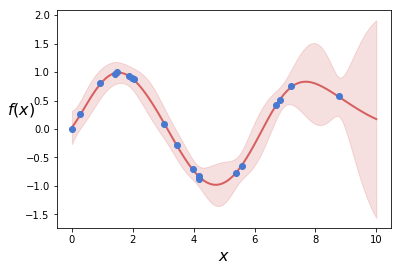

In [14]:
np.random.seed(1)
eta = 1
rho = 0.5
sigma = 0.03

# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(x).flatten()

# Define the kernel
def kernel(a, b):
    """ GP squared exponential kernel """
    D = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return eta * np.exp(- rho * D)

N = 20         # number of training points.
n = 100         # number of test points.

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = np.random.uniform(0, 10, size=(N,1))
y = f(X) + sigma * np.random.randn(N)

K = kernel(X, X)
L = np.linalg.cholesky(K + sigma * np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(0, 10, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)
sd_pred = (np.diag(K_) - np.sum(Lk**2, axis=0))**0.5


plt.fill_between(Xtest.flat, mu - 2 * sd_pred, mu + 2 * sd_pred, color="r", alpha=0.2)
plt.plot(Xtest, mu, 'r', lw=2)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0);

In [15]:
with pm.Model() as GP:
    mu = np.zeros(N)
    eta = pm.HalfCauchy('eta', 5)
    rho = pm.HalfCauchy('rho', 5)
    sigma = pm.HalfCauchy('sigma', 5)
    
    D = squared_distance(x, x)
    
    K = tt.fill_diagonal(eta * pm.math.exp(-rho * D), eta + sigma)
    
    obs = pm.MvNormal('obs', mu, cov=K, observed=y)

    test_points = np.linspace(0, 10, 100)
    D_pred = squared_distance(test_points, test_points)
    D_off_diag = squared_distance(x, test_points)
    
    K_oo = eta * pm.math.exp(-rho * D_pred)
    K_o = eta * pm.math.exp(-rho * D_off_diag)
    
    mu_post = pm.Deterministic('mu_post', pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), y))
    SIGMA_post = pm.Deterministic('SIGMA_post', K_oo - pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), K_o.T))
    
    #start = pm.find_MAP()
    trace = pm.sample(1000, chains=1,njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequenc

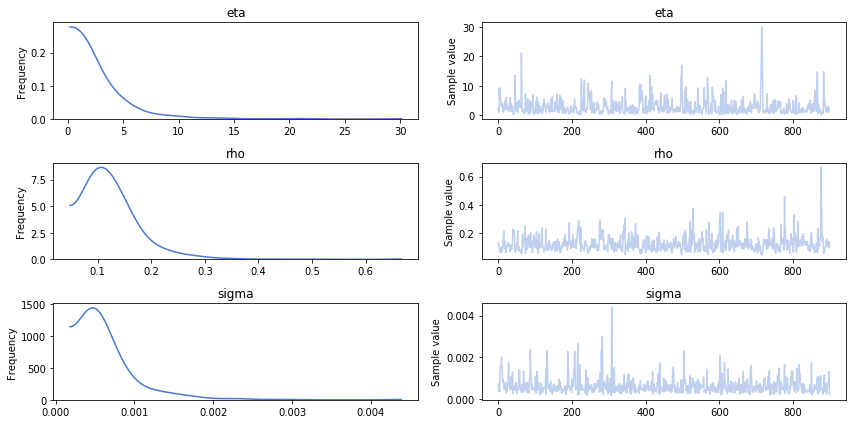

In [16]:
varnames = ['eta', 'rho', 'sigma']
chain = trace[100:]
pm.traceplot(chain, varnames);

In [17]:
pm.summary(chain, varnames).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
eta,2.8176,2.8098,0.1533,0.2049,7.8822
rho,0.1272,0.0537,0.0028,0.0510,0.2265
sigma,0.0006,0.0004,0.0000,0.0002,0.0014


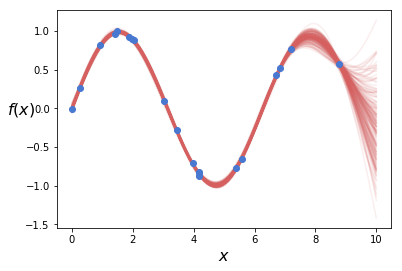

In [18]:
y_pred = [np.random.multivariate_normal(m, S) for m,S in zip(chain['mu_post'][::5], chain['SIGMA_post'][::5])]

for yp in y_pred:
    plt.plot(test_points, yp, 'r-', alpha=0.1)

plt.plot(x, y, 'bo');
plt.xlabel('$x$', fontsize=16);
plt.ylabel('$f(x)$', fontsize=16, rotation=0);

# Periodic Kernel

In [19]:
periodic = lambda x, y: np.array([[np.sin((x[i] - y[j])/2)**2 for i in range(len(x))] for j in range(len(y))])

In [20]:
with pm.Model() as GP_periodic:
    mu = np.zeros(N)
    eta = pm.HalfCauchy('eta', 5)
    rho = pm.HalfCauchy('rho', 5)
    sigma = pm.HalfCauchy('sigma', 5)
    
    P = periodic(x, x)
    
    K = tt.fill_diagonal(eta * pm.math.exp(-rho * P), eta + sigma)
    
    obs = pm.MvNormal('obs', mu, cov=K, observed=y)

    test_points = np.linspace(0, 10, 100)
    D_pred = periodic(test_points, test_points)
    D_off_diag = periodic(x, test_points)
    
    K_oo = eta * pm.math.exp(-rho * D_pred)
    K_o = eta * pm.math.exp(-rho * D_off_diag)
    
    mu_post = pm.Deterministic('mu_post', pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), y))
    SIGMA_post = pm.Deterministic('SIGMA_post', K_oo - pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), K_o.T))
    
    start = pm.find_MAP()
    trace = pm.sample(1000, start=start,chains=1,njobs=1)

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `a

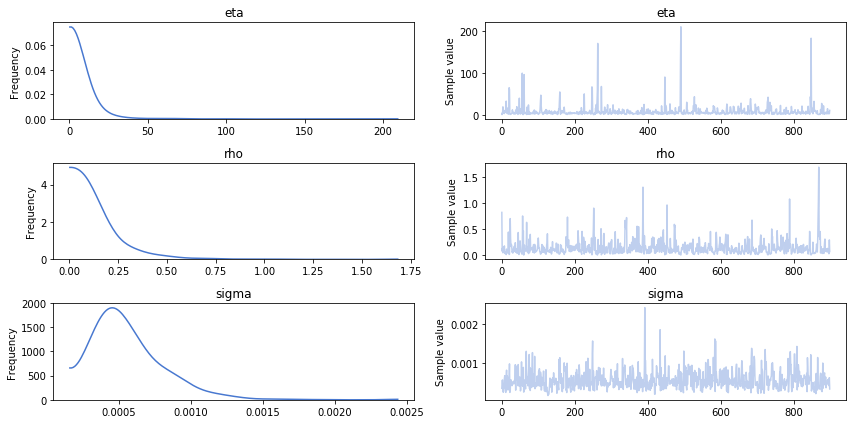

In [21]:
varnames = ['eta', 'rho', 'sigma']
chain = trace[100:]
pm.traceplot(chain, varnames);

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  """Entry point for launching an IPython kernel.


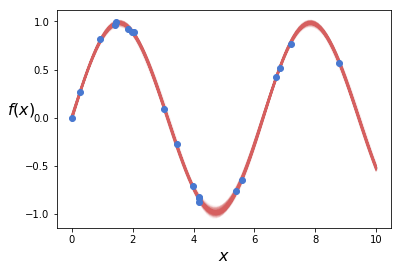

In [22]:
y_pred = [np.random.multivariate_normal(m, S) for m,S in zip(chain['mu_post'][::5], chain['SIGMA_post'][::5])]

for yp in y_pred:
    plt.plot(test_points, yp, 'r-', alpha=0.1)

plt.plot(x, y, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0);

In [23]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nPandas %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, pd.__version__, matplotlib.__version__, sns.__version__))

This notebook was created on a computer x86_64 running debian buster/sid and using:
Python 3.7.2
IPython 7.2.0
PyMC3 3.6
NumPy 1.16.0
SciPy 1.2.0
Pandas 0.23.4
Matplotlib 3.0.2
Seaborn 0.9.0



/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  
